In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

from openpathsampling.analysis.tis_analysis import TISTransition

storage = paths.storage.Storage("toy_tis.nc")
print len(storage.sample)

126


In [2]:
print len(storage.sampleset)

123


In [3]:
print storage.sampleset[0].samples

[<Sample @ 0x10a6a2ad0>, <Sample @ 0x10a6a2450>, <Sample @ 0x10a6a2c10>, <Sample @ 0x10a6a2810>, <Sample @ 0x10a6a2d50>, <Sample @ 0x10a6cb650>]


In [4]:
ensembles=storage.ensemble[:]

In [5]:
ensembles

In [6]:
stateA = ensembles[1].ensembles[2].ensemble.volume.volume1
stateB = ensembles[1].ensembles[2].ensemble.volume.volume2
interfaces = [e.ensembles[1].ensemble2.volume for e in ensembles[1:]]
op = ensembles[1].ensembles[0].ensemble.volume.orderparameter

In [7]:
lmax = [e.ensembles[1].ensemble2.volume.lambda_max for e in ensembles[1:]]
print lmax

[0.0, -0.25, -0.3, -0.2, -0.13]


In [8]:
tis = TISTransition(stateA=stateA, stateB=stateB, orderparameter=op, interfaces=interfaces, name="A->B", storage=storage)

In [9]:
tis.ensembles = ensembles
for ensemble in tis.ensembles:
    ensemble.name = "I'face "+str(tis.ensembles.index(ensemble))

In [10]:
tis.ensemble_histogram_info['pathlength'].hist_args = { 'bin_width' : 5, 'bin_range' : (0, 100) }
tis.ensemble_histogram_info['max_lambda'].hist_args = { 'bin_width' : 0.05, 'bin_range' : (-0.35, 0.35) }

In [11]:
%%time
tis.all_statistics(samples=storage.sample, weights=None, force=True)

CPU times: user 2.67 s, sys: 62.7 ms, total: 2.73 s
Wall time: 2.77 s


In [12]:
tis.histograms

{'max_lambda': {<openpathsampling.ensemble.SequentialEnsemble at 0x102317e10>: <openpathsampling.analysis.histogram.Histogram at 0x103f36f50>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x10a6a2210>: <openpathsampling.analysis.histogram.Histogram at 0x10aa18150>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x10a6a2310>: <openpathsampling.analysis.histogram.Histogram at 0x10aaa2690>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x10a6a2610>: <openpathsampling.analysis.histogram.Histogram at 0x10abceb90>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x10a6a2790>: <openpathsampling.analysis.histogram.Histogram at 0x10ab1b910>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x10a6a28d0>: <openpathsampling.analysis.histogram.Histogram at 0x10ab61f90>},
 'pathlength': {<openpathsampling.ensemble.SequentialEnsemble at 0x102317e10>: <openpathsampling.analysis.histogram.Histogram at 0x10a6c5e10>,
  <openpathsampling.ensemble.SequentialEnsemble at 0x10a6a2210>: <op

In [13]:
#print tis.histograms
# storage.save(tis)

In [14]:
%%time
#storage.sample.cache = {}
#storage.trajectory.cache = {}
for samp in (s for s in storage.sample if s.ensemble==tis.ensembles[1]):
    len(samp.trajectory)

CPU times: user 26.7 ms, sys: 3.39 ms, total: 30.1 ms
Wall time: 30.3 ms


In [15]:
# for sample_set[ssetid], if exists sample in `ensemble`, return list of op(sample.trajectory)
#storage.query_orderparameter_trajectory(orderparameter, ensemble=None, replica=None, step=None, trial=False) #

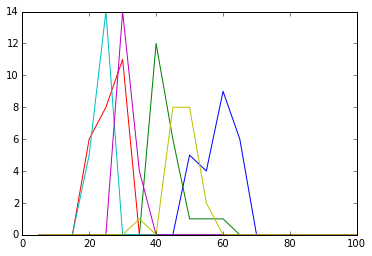

In [16]:
for ens in tis.ensembles:
    myhist = tis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.histogram())

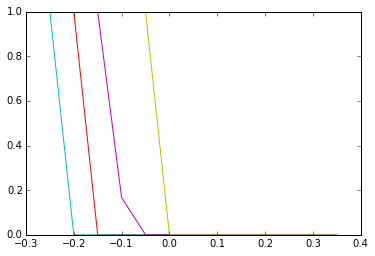

In [17]:
for ens in tis.ensembles:
    myhist = tis.histograms['max_lambda'][ens]
    plt.plot(myhist.plot_bins(), myhist.reverse_cumulative())

In [18]:
#import pandas as pd
#frames = []
#for ens in tis.ensembles:
#    myhist = tis.histograms['pathlength'][ens]
#    myhist.name =  "Pathlength A->B Interface " + str(tis.ensembles.index(ens))
#    frames.append(pd.DataFrame({myhist.name : myhist.histogram()}, index=myhist.plot_bins()))
#all_frames = pd.concat(frames, axis=1)
#print all_frames

In [19]:
from openpathsampling.analysis.histogram import histograms_to_pandas_dataframe
print histograms_to_pandas_dataframe(tis.histograms['pathlength'].values())

     pathlength A->B I'face 0  pathlength A->B I'face 5  \
5                           0                         0   
10                          0                         0   
15                          0                         0   
20                          0                         0   
25                          0                         0   
30                          0                         0   
35                          0                         1   
40                          0                         0   
45                          0                         8   
50                          5                         8   
55                          4                         2   
60                          9                         0   
65                          6                         0   
70                          0                         0   
75                          0                         0   
80                          0                         0 